# Effects of Different Integration Methods on HH Neuron Dynamics

This example implements the classic Hodgkin-Huxley model to compare the effects of the exponential Euler method `exp_euler` and the independent exponential Euler method `ind_exp_euler` on the neuron's membrane potential dynamics. You will learn how to configure different integrators in `braincell` and understand their differences when simulating neuronal electrical activity.

## Preparation

First, make sure the necessary libraries (`braincell`, `brainstate`, `brainunit`, `matplotlib`) are installed, and import the required modules:

In [13]:
import brainstate
import brainunit as u
import matplotlib.pyplot as plt
import braincell

## Code Explanation

### Define HH Model Neuron

Use `SingleCompartment` to construct a single neuron based on the HH model, including sodium channel `INa`, potassium channel `IK`, and leak current `IL`. These channels collectively determine the neuron's firing characteristics:


In [14]:
class HH(braincell.SingleCompartment):
    def __init__(self, size, solver='rk4'):
        super().__init__(size, solver=solver)

        self.na = braincell.ion.SodiumFixed(size, E=50. * u.mV)
        self.na.add(INa=braincell.channel.INa_HH1952(size))

        self.k = braincell.ion.PotassiumFixed(size, E=-77. * u.mV)
        self.k.add(IK=braincell.channel.IK_HH1952(size))

        self.IL = braincell.channel.IL(
            size,
            E=-54.387 * u.mV,
            g_max=0.03 * (u.mS / u.cm **2)
        )

### Initialize Neurons and Configure Integration Methods

Create two HH neuron instances, using the standard exponential Euler method `exp_euler` and the independent exponential Euler method `ind_exp_euler`, respectively, and initialize the neuron states:


In [15]:
# Create an HH neuron using the standard exponential Euler method
hh_exp = HH(1, solver='exp_euler')

# Create an HH neuron using the independent exponential Euler method
hh_ind_exp = HH(1, solver='ind_exp_euler')

# Initialize neuron states (such as membrane potential, gating variables, etc.) to resting state
hh_exp.init_state()
hh_ind_exp.init_state()


### Define the simulation step function

Write a function that describes the update rules of the neuron at each time step, including receiving input current and returning the membrane potential:


In [16]:
def step_fun(t, neuron):
    # Update the neuron's state at the current time t
    with brainstate.environ.context(t=t):
        # Inject a constant current to the neuron to evoke action potentials
        neuron.update(10 * u.nA / u.cm**2)
    # Return the current membrane potential value
    return neuron.V.value


### Run simulation and record results

Set up the simulation parameters and run the simulations for the two integration methods, recording the membrane potential changes over time:


In [17]:
# Set simulation time step
with brainstate.environ.context(dt=0.1 * u.ms):
    # Generate simulation time series
    times = u.math.arange(0. * u.ms, 100 * u.ms, brainstate.environ.get_dt())

    # Simulate using standard exponential Euler method and record membrane potential
    vs_exp = brainstate.transform.for_loop(
        lambda t: step_fun(t, hh_exp),
        times
    )

    # Simulate using independent exponential Euler method and record membrane potential
    vs_ind_exp = brainstate.transform.for_loop(
        lambda t: step_fun(t, hh_ind_exp),
        times
    )


### Visualize Membrane Potential Dynamics

Plot the membrane potential traces under the two integration methods to compare the differences in action potential waveforms:


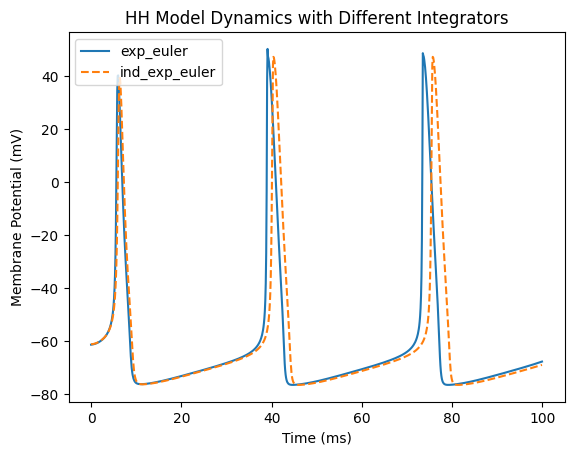

In [18]:
# Plot the results using standard exponential Euler
plt.plot(times, u.math.squeeze(vs_exp), label='exp_euler', linewidth=1.5)

# Plot the results using independent exponential Euler
plt.plot(times, u.math.squeeze(vs_ind_exp), label='ind_exp_euler', linestyle='--', linewidth=1.5)

# Add labels and legend
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.legend()
plt.title('HH Model Dynamics with Different Integrators')
plt.show()


## Result Interpretation

After running the code, you will see the membrane potential over time.

Key conclusions:
Action potential characteristics: Both methods can simulate the generation of action potentials, but the waveform details differ.
Integrator differences:
   - `exp_euler` produces smoother curves, fitting the relationship between tightly coupled gating variables and membrane potential more accurately, with action potential peaks and time courses closer to theoretical values.
   - `ind_exp_euler` updates state variables independently, which may introduce slight deviations during rapid changes, but it is faster, especially for large-scale simulations.
Applicable scenarios:
   - For high-precision single-cell simulations, such as reproducing specific electrophysiological experiments, prefer `exp_euler`.
   - For large-scale network simulations involving thousands of neurons, `ind_exp_euler` can significantly improve efficiency while maintaining sufficient accuracy.

## Extended Exercises

- Try using the fourth-order Runge-Kutta method `solver='rk4'` and compare its accuracy and computational efficiency with exponential Euler methods.
- Adjust the input current intensity to observe how different integrators affect neuronal firing frequency.
- Extend the simulation duration to analyze the cumulative effect of integration errors over long-term simulations.

Through these exercises, you will gain a deeper understanding of the critical role of numerical methods in neural simulations and provide guidance for complex model design.

## More

For more numerical integration methods, we provide a rich set of integrators and related resources in the [Numerical Integration Methods Library](https://braincell.readthedocs.io/latest/apis/integration.html).
